In [7]:
import yaml
import numpy as np
import mplhep as hep
import matplotlib.pyplot as plt
from coffea import util
from coffea import processor
from matplotlib.lines import Line2D
from hist.intervals import ratio_uncertainty
from matplotlib.offsetbox import AnchoredText
from coffea.lookup_tools.dense_lookup import dense_lookup


hep.style.use(hep.style.CMS)
with open("../analysis/postprocess/luminosity.yaml", "r") as f:
    luminosities = yaml.safe_load(f)
with open("../analysis/postprocess/style.yaml", "r") as f:
    style = yaml.safe_load(f)
plt.rcParams.update(style["rcParams"])

In [8]:
def get_eff_sf(eff_hist, wp, eta_region, jet_flavor):
    flavor_tags = {"light": 0, "c": 1, "b": 2}
    selector = {"jet_flavor": flavor_tags[jet_flavor]}
    if eta_region == "barrel":
        selector.update({"jet_abseta": slice(0.0j, 1.3j, sum)})
    else:
        selector.update({"jet_abseta": slice(1.3j, 2.5j, sum)})

    selector_numerator = {**selector, f"jet_pass_{wp}_wp": True}
    selector_denominator = {**selector, f"jet_pass_{wp}_wp": sum}

    numerator = eff_hist[f"eff_{wp}"][selector_numerator]
    denominator = eff_hist[f"eff_{wp}"][selector_denominator]
    efficiency = numerator / denominator

    centers = efficiency.axes[0].centers
    edges = efficiency.axes[0].edges
    xerr = edges[1:] - edges[:-1]
    yerr = ratio_uncertainty(
        num=numerator.values(),
        denom=denominator.values(),
        uncertainty_type="efficiency",
    )

    return efficiency.values(), centers, xerr, yerr

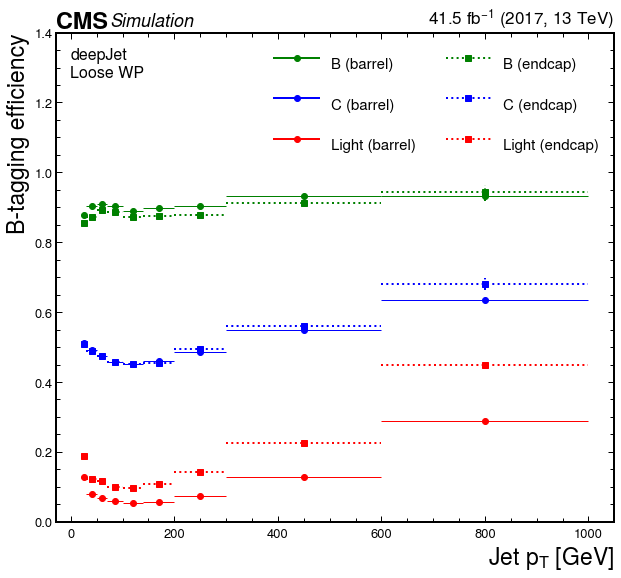

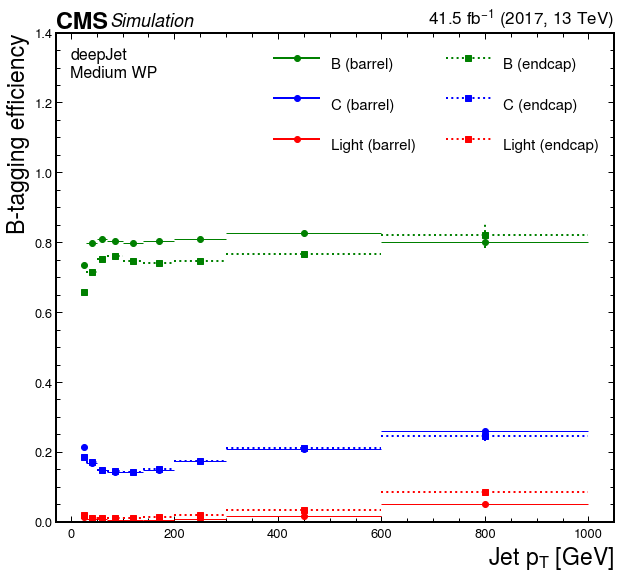

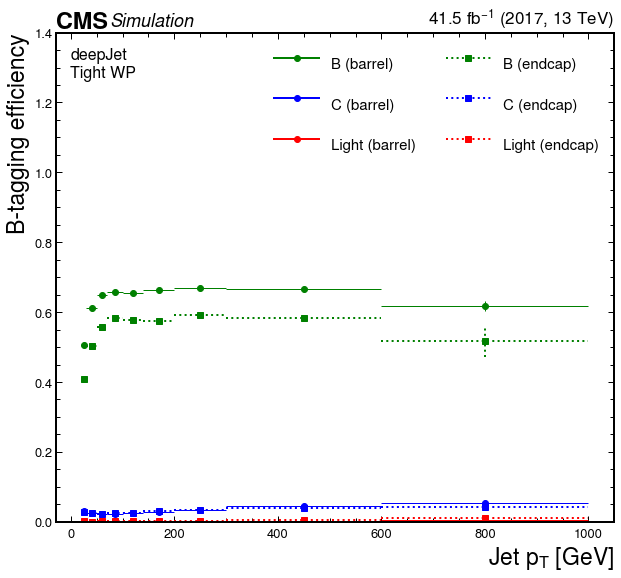

In [9]:
workflow = "btag_eff_mu"
year = "2017"

run = "2" if year.startswith("201") else "3"
energy = "13" if run == '2' else "13.6"
tagger_map = {"2": "deepJet", "3": "ParticleNet"}

# Load processed histograms from btag_eff workflow
processed_histograms = util.load(
    f"../outputs/{workflow}/{year}/{year}_processed_histograms.coffea"
)
btag_eff_hist = processor.accumulate(processed_histograms.values())

for wp in ["loose", "medium", "tight"]:
    # save b-tagging efficiency lookup table
    numerator = btag_eff_hist[f"eff_{wp}"][{f"jet_pass_{wp}_wp": True}]
    denominator = btag_eff_hist[f"eff_{wp}"][{f"jet_pass_{wp}_wp": sum}]
    efficiency = numerator / denominator
    efflookup = dense_lookup(efficiency.values(), [ax.edges for ax in efficiency.axes])
    efflookup._axes[-1] = np.array([0.0, 4.0, 5.0, 6.0])

    output_path = (
        f"../analysis/data/btag_efficiencies/{workflow}_{wp}_{year}.coffea"
    )
    util.save(efflookup, output_path)

    # plot b-tagging efficiencies
    eff_barrel_light, centers, xerr_barrel_light, yerr_barrel_light = get_eff_sf(
        btag_eff_hist, wp=wp, eta_region="barrel", jet_flavor="light"
    )
    eff_barrel_c, centers, xerr_barrel_c, yerr_barrel_c = get_eff_sf(
        btag_eff_hist, wp=wp, eta_region="barrel", jet_flavor="c"
    )
    eff_barrel_b, centers, xerr_barrel_b, yerr_barrel_b = get_eff_sf(
        btag_eff_hist, wp=wp, eta_region="barrel", jet_flavor="b"
    )

    eff_endcap_light, centers, xerr_endcap_light, yerr_endcap_light = get_eff_sf(
        btag_eff_hist, wp=wp, eta_region="endcap", jet_flavor="light"
    )
    eff_endcap_c, centers, xerr_endcap_c, yerr_endcap_c = get_eff_sf(
        btag_eff_hist, wp=wp, eta_region="endcap", jet_flavor="c"
    )
    eff_endcap_b, centers, xerr_endcap_b, yerr_endcap_b = get_eff_sf(
        btag_eff_hist, wp=wp, eta_region="endcap", jet_flavor="b"
    )

    fig, ax = plt.subplots(figsize=(10, 9))
    errorbar_container1 = ax.errorbar(
        centers,
        eff_barrel_light,
        xerr=xerr_barrel_light / 2,
        yerr=yerr_barrel_light,
        fmt="ro",
        elinewidth=1,
        linestyle="solid",
        linewidth=0,
        markersize=6,
    )
    errorbar_container2 = ax.errorbar(
        centers,
        eff_barrel_c,
        xerr=xerr_barrel_c / 2,
        yerr=yerr_barrel_c,
        fmt="bo",
        elinewidth=1,
        linestyle="solid",
        linewidth=0,
        markersize=6,
    )
    errorbar_container3 = ax.errorbar(
        centers,
        eff_barrel_b,
        xerr=xerr_barrel_b / 2,
        yerr=yerr_barrel_b,
        fmt="go",
        elinewidth=1,
        linestyle="solid",
        linewidth=0,
        markersize=6,
    )

    errorbar_container4 = ax.errorbar(
        centers,
        eff_endcap_light,
        xerr=xerr_endcap_light / 2,
        yerr=yerr_endcap_light,
        fmt="rs",
        elinewidth=1,
        linewidth=0,
        markersize=6,
    )
    errorbar_container5 = ax.errorbar(
        centers,
        eff_endcap_c,
        xerr=xerr_endcap_c / 2,
        yerr=yerr_endcap_c,
        fmt="bs",
        elinewidth=1,
        linewidth=0,
        markersize=6,
    )
    errorbar_container6 = ax.errorbar(
        centers,
        eff_endcap_b,
        xerr=xerr_endcap_b / 2,
        yerr=yerr_endcap_b,
        fmt="gs",
        elinewidth=1,
        linewidth=0,
        markersize=6,
    )
    for bar in errorbar_container4[2]:
        bar.set_linestyle(":")
        bar.set_linewidth(2)
    for bar in errorbar_container5[2]:
        bar.set_linestyle(":")
        bar.set_linewidth(2)
    for bar in errorbar_container6[2]:
        bar.set_linestyle(":")
        bar.set_linewidth(2)

    legend_elements = [
        Line2D(
            [0],
            [0],
            color="g",
            linewidth=2,
            linestyle="-",
            marker="o",
            markersize=6,
            label="B (barrel)",
        ),
        Line2D(
            [0],
            [0],
            color="b",
            linewidth=2,
            linestyle="-",
            marker="o",
            markersize=6,
            label="C (barrel)",
        ),
        Line2D(
            [0],
            [0],
            color="r",
            linewidth=2,
            linestyle="-",
            marker="o",
            markersize=6,
            label="Light (barrel)",
        ),
        Line2D(
            [0],
            [0],
            color="g",
            linewidth=2,
            linestyle=":",
            marker="s",
            markersize=6,
            label="B (endcap)",
        ),
        Line2D(
            [0],
            [0],
            color="b",
            linewidth=2,
            linestyle=":",
            marker="s",
            markersize=6,
            label="C (endcap)",
        ),
        Line2D(
            [0],
            [0],
            color="r",
            linewidth=2,
            linestyle=":",
            marker="s",
            markersize=6,
            label="Light (endcap)",
        ),
    ]
    ax.legend(
        handles=legend_elements,
        loc="upper right",
        handlelength=3,
        handleheight=3,
        fontsize=15,
        ncols=2,
    )
    ax.set(
        ylim=(0, 1.4),
        ylabel="B-tagging efficiency",
        xlabel="Jet $p_T$ [GeV]",
    )
    ax.add_artist(
        AnchoredText(
            f"{tagger_map[run]}\n{wp.capitalize()} WP",
            loc="upper left",
            frameon=False,
            prop={'size': 16}
        )
    )
    hep.cms.lumitext(
        f"{luminosities[year] * 1e-3:.1f} fb$^{{-1}}$ ({year}, {energy} TeV)"
    )
    hep.cms.text("Simulation", loc=0, ax=ax)